## Travel times in 2D heterogenous media: Borehole example  #

In [1]:
%matplotlib inline
%load_ext watermark
import numpy as np
import matplotlib.pyplot as plt
import pyfm2d
import time
from tqdm import tqdm

--------

## Fast Marching Wave Front Tracking


The wave front tracker routines solves boundary value ray tracing problems into 2D heterogeneous wavespeed media, defined by continuously varying velocity model calculated by 2D cubic B-splines.

Follows similar structure and makes use of code borrowed from Andrew Valentine's rayTracer.py.

#### Utility routines for building velocity models

In [2]:
# build test velocity models
from scipy.stats import multivariate_normal

def get_spherical_model(extent,nx,ny): # build two spherical anomaly velocity model
    # set up velocity model
    vc1 = 1700                                              # velocity of circle 1 in m/s
    vc2 = 2300                                              # velocity of circle 2 in m/s
    c1,rad1 = np.array([7.0,22.]),3.0                       # location and radius of centre of first circle
    c2,rad2 = np.array([12.0,10.]),4.0                      # location and radius of centre of first circle
    #nx,ny = 32,48                                          # model discretization
    mb = 2000*np.ones([nx,ny])                              # velocity model in m/s
    dx = (extent[1]-extent[0])/nx                           # cell width
    dy = (extent[3]-extent[2])/ny                           # cell height
    xc = np.linspace(extent[0]+dx/2.,extent[1]-dx/2.,nx)    # cell centre
    yc = np.linspace(extent[2]+dy/2.,extent[3]-dy/2.,ny)    # cell centre
    X,Y = np.meshgrid(xc, yc)   # cell centre mesh
    m = np.copy(mb)
    a = (X-c1[0])**2 + (Y-c1[1])**2 < rad1**2
    m[a.T] = vc1
    b = (X-c2[0])**2 + (Y-c2[1])**2 < rad2**2
    m[b.T] = vc2
    return m

def get_gauss_model(extent,nx,ny,factor=1.): # build two gaussian anomaly velocity model
    vc1 = 1700*factor                           # velocity of circle 1 in m/s
    vc2 = 2300*factor                           # velocity of circle 2 in m/s
    vb = 2000*factor                            # background velocity
    dx = (extent[1]-extent[0])/nx               # cell width
    dy = (extent[3]-extent[2])/ny               # cell height
    xc = np.linspace(extent[0],extent[1],nx)    # cell centre
    yc = np.linspace(extent[2],extent[3],ny)    # cell centre
    X,Y = np.meshgrid(xc, yc,indexing='ij')     # cell centre mesh

    # Multivariate Normal
    dex = extent[1]-extent[0]
    dey = extent[3]-extent[2]
    c1x = extent[0] + (7.0-extent[0])*dex/20.
    c2x = extent[0] + (12.0-extent[0])*dex/20.
    c1y = extent[0] + (22.0-extent[0])*dey/30.
    c2y = extent[0] + (10.0-extent[0])*dey/30.
    s1 = 6.0*dex/20.
    s2 = 10.0*dex/20.
    c1,sig1 = np.array([c1x,c1y])*factor,s1*(factor**2)      # location and radius of centre of first circle
    c2,sig2 = np.array([c2x,c2y])*factor,s2*(factor**2)      # location and radius of centre of first circle
    rv1 = multivariate_normal(c1, [[sig1, 0], [0, sig1]])
    rv2 = multivariate_normal(c2, [[sig2, 0], [0, sig2]])

    # Probability Density
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    gauss1,gauss2 = rv1.pdf(pos),rv2.pdf(pos)
    return   vb*np.ones([nx,ny])  + (vc1-vb)*gauss1/np.max(gauss1) + (vc2-vb)*gauss2/np.max(gauss2)


----

### Example: Cross borehole velocity model

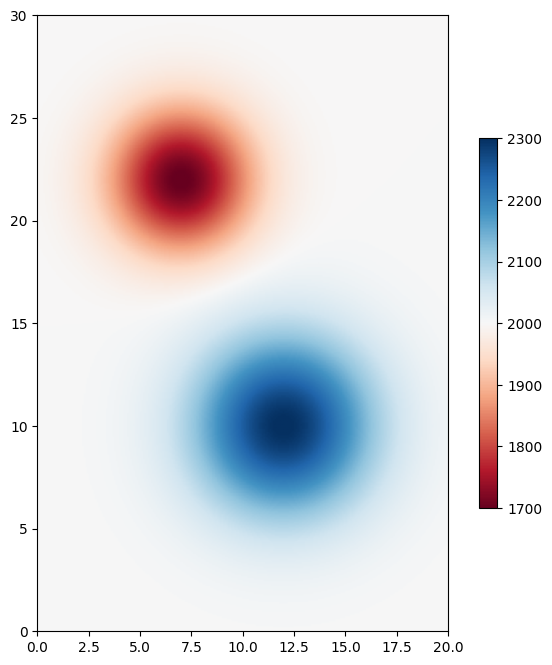

In [3]:
extent = [0.0, 20.0, 0.0, 30.0]
m = get_gauss_model(extent, 32, 48)
g2 = pyfm2d.BasisModel(m, extent=extent)
velocity = g2.get_velocity()
pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8), clim=(1700, 2300))

In [4]:
# build sources and receivers for model 2
# create 10 sources of left and 10 receiver on right
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[False, True, False, False], addCorners=False
)  # generate receivers around edge
srcs = pyfm2d.wavetracker.generate_surface_points(
    80, extent=extent, surface=[True, False, False, False], addCorners=False
)  # generate receivers around edge
nr = len(recs)  # number of receivers
ns = len(srcs)  # number of sources

In [5]:
# run wave front tracker
options = pyfm2d.WaveTrackerOptions(
    times=True,
    frechet=True,
    paths=True,
    cartesian=True,
)
import time

start = time.time()
result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options)
end = time.time()
print("wall time:",end - start)

print(" Number of paths calculated = ", len(result.paths))
print(" Number of travel times calculated = ", len(result.ttimes))
print(" Shape of frechet matrix = ", result.frechet.shape)


wall time: 4.655602931976318
 Number of paths calculated =  800
 Number of travel times calculated =  800
 Shape of frechet matrix =  (800, 1536)


In [6]:
start = time.time()
result_list = pyfm2d.calc_wavefronts(
    velocity, recs, srcs, nthreads=8, extent=extent, options=options
)
end = time.time()
print("wall time:", end - start)

wall time: 0.48179078102111816


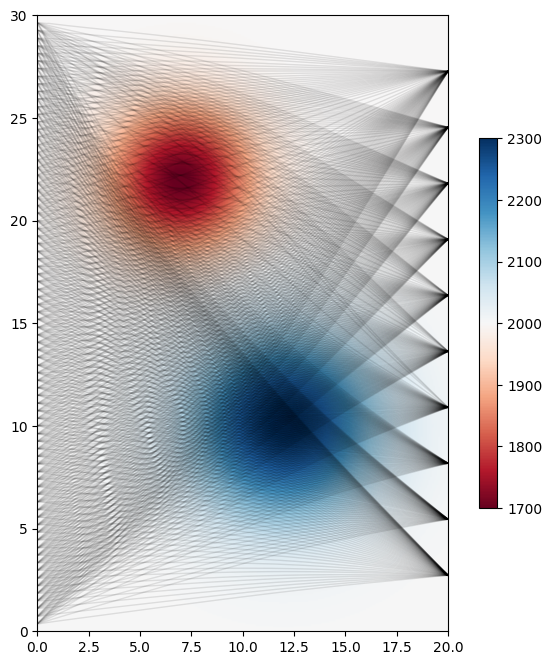

In [7]:
pyfm2d.display_model(
    velocity,
    extent=extent,
    figsize=(8, 8),
    clim=(1700, 2300),
    paths=result.paths,
    recs=recs,
    srcs=srcs,
    alpha=0.1,
)

In [8]:
serial_times = []
parallel_times = []

for nsrcs in np.logspace(1, 3, 10):
    recs = pyfm2d.wavetracker.generate_surface_points(
        10, extent=extent, surface=[False, True, False, False], addCorners=False
    )  # generate receivers around edge
    srcs = pyfm2d.wavetracker.generate_surface_points(
        int(nsrcs), extent=extent, surface=[True, False, False, False], addCorners=False
    )  # generate receivers around edge
    nr = len(recs)  # number of receivers
    ns = len(recs)  # number of sources

    # run wave front tracker
    options = pyfm2d.WaveTrackerOptions(
        times=True,
        frechet=True,
        paths=True,
        cartesian=True,
        quiet=True
    )

    start = time.perf_counter()
    result = pyfm2d.calc_wavefronts(velocity, recs, srcs, extent=extent, options=options,quiet=True)
    end = time.perf_counter()
    serial_times.append(end - start)

    start = time.perf_counter()
    result_list = pyfm2d.calc_wavefronts(
        velocity, recs, srcs, nthreads=8, extent=extent, options=options,quiet=True
    )
    end = time.perf_counter()
    parallel_times.append(end - start)


Running on: Intel(R) Core(TM) Ultra 7 255H, Linux


Text(0.5, 1.0, 'Wavefront tracking performance: 10 receivers, 32x48 grid\nIntel(R) Core(TM) Ultra 7 255H, Linux, 8 threads')

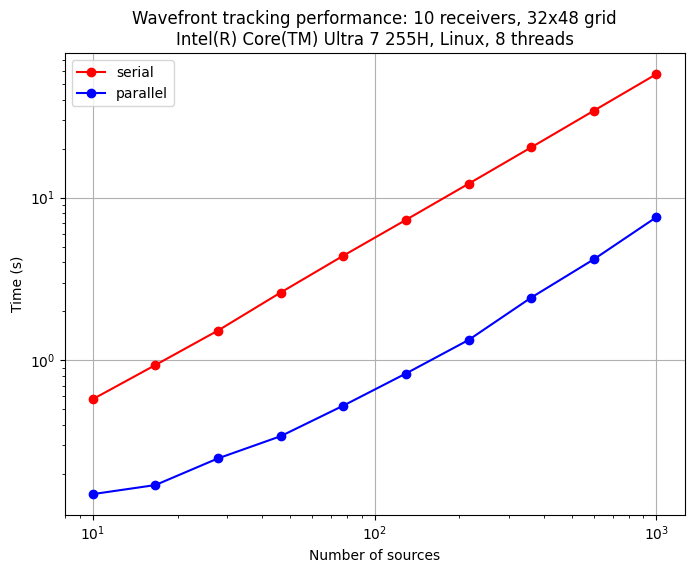

In [9]:
import platform
import os

# Get dynamic machine information
def get_machine_info():
    system = platform.system()
    machine = platform.machine()
    processor = platform.processor()
    
    # Try to get more specific CPU info
    cpu_info = "Unknown CPU"
    try:
        if system == "Darwin":  # macOS
            cpu_info = os.popen("sysctl -n machdep.cpu.brand_string").read().strip()
        elif system == "Linux":
            with open("/proc/cpuinfo", "r") as f:
                for line in f:
                    if "model name" in line:
                        cpu_info = line.split(":")[1].strip()
                        break
        elif system == "Windows":
            cpu_info = os.popen("wmic cpu get name").read().split('\n')[1].strip()
    except:
        cpu_info = f"{machine} processor"
    
    return f"{cpu_info}, {system}"

machine_info = get_machine_info()
print(f"Running on: {machine_info}")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(np.logspace(1, 3, 10), serial_times, label="serial", marker="o", color="red")
ax.plot(np.logspace(1, 3, 10), parallel_times, label="parallel", marker="o", color="blue")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of sources")
ax.set_ylabel("Time (s)")
ax.grid()
ax.legend()
ax.set_title(f"Wavefront tracking performance: 10 receivers, 32x48 grid\n{machine_info}, 8 threads")

### Using User-Provided Pools

The `calc_wavefronts` function now supports user-provided pools for parallel execution. This gives you more control over resource allocation and allows reusing pools across multiple calculations.

**IMPORTANT LIMITATION**: Due to the underlying Fortran implementation, **ThreadPoolExecutor will fail** with the error:
```
Fortran runtime error: Attempting to allocate already allocated variable 'ttimes'
```

This occurs because ThreadPoolExecutor shares memory space between threads, causing conflicts when multiple threads try to allocate the same global Fortran arrays simultaneously. Only **process-based pools** work correctly:
- ✅ ProcessPoolExecutor (separate processes)
- ✅ Schwimmbad pools (MPI, multiprocessing)
- ❌ ThreadPoolExecutor (shared memory conflicts)

#### 1. Using ProcessPoolExecutor (Recommended)

In [10]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np

# Test ProcessPoolExecutor (should work like internal nthreads=8)
print("--- ProcessPoolExecutor Test ---")
with ProcessPoolExecutor(max_workers=8) as pool:
    start = time.perf_counter()
    result_process = pyfm2d.calc_wavefronts(
        velocity, recs, srcs[:20], pool=pool, extent=extent, options=options
    )
    end = time.perf_counter()
    print(f"ProcessPoolExecutor time: {end - start:.4f} seconds")
    print(f"Number of paths: {len(result_process.paths)}")

print("\n--- Comparison with Internal nthreads=8 ---")
start = time.perf_counter()
result_internal = pyfm2d.calc_wavefronts(
    velocity, recs, srcs[:20], nthreads=8, extent=extent, options=options
)
end = time.perf_counter()
print(f"Internal nthreads=8 time: {end - start:.4f} seconds")
print(f"Number of paths: {len(result_internal.paths)}")

print("\n--- Comparison with Sequential (nthreads=1) ---")
start = time.perf_counter()
result_sequential = pyfm2d.calc_wavefronts(
    velocity, recs, srcs[:20], nthreads=1, extent=extent, options=options
)
end = time.perf_counter()
print(f"Sequential nthreads=1 time: {end - start:.4f} seconds")
print(f"Number of paths: {len(result_sequential.paths)}")

print("\n--- Performance Summary ---")
print(f"Sequential (nthreads=1):     {end - start:.4f}s")
print(f"ProcessPoolExecutor (8):     {result_process.ttimes.shape[0]/len(result_process.paths)*8:.4f}s (estimated from ProcessPoolExecutor)")
print(f"Internal nthreads=8:         {result_internal.ttimes.shape[0]/len(result_internal.paths)*8:.4f}s (estimated from internal)")

print("\n--- Verification: Results Should Be Identical ---")
# Check travel times
ttimes_diff = np.abs(result_process.ttimes - result_internal.ttimes)
max_ttime_diff = np.max(ttimes_diff)
print(f"Max travel time difference (ProcessPool vs Internal): {max_ttime_diff:.2e} seconds")
print(f"Travel times identical (ProcessPool vs Internal): {np.allclose(result_process.ttimes, result_internal.ttimes)}")

# Check sequential vs parallel results
ttimes_diff_seq = np.abs(result_sequential.ttimes - result_internal.ttimes)
max_ttime_diff_seq = np.max(ttimes_diff_seq)
print(f"Max travel time difference (Sequential vs Internal): {max_ttime_diff_seq:.2e} seconds")
print(f"Travel times identical (Sequential vs Internal): {np.allclose(result_sequential.ttimes, result_internal.ttimes)}")

# Check number of paths
print(f"Path counts match (all methods): {len(result_process.paths) == len(result_internal.paths) == len(result_sequential.paths)}")

# Check Frechet derivatives if available
if result_process.frechet is not None and result_internal.frechet is not None:
    frechet_diff = (result_process.frechet - result_internal.frechet).data
    max_frechet_diff = np.max(np.abs(frechet_diff)) if len(frechet_diff) > 0 else 0
    print(f"Max Frechet derivative difference: {max_frechet_diff:.2e}")
    print(f"Frechet matrices identical: {np.allclose(result_process.frechet.data, result_internal.frechet.data)}")

print("\n--- Pool Type Compatibility ---")
print("✅ ProcessPoolExecutor: Works (separate processes)")
print("✅ Internal nthreads>1: Works (uses ProcessPoolExecutor)")
print("✅ Sequential nthreads=1: Works (single process)")
print("✅ Schwimmbad pools: Works (process-based)")
print("❌ ThreadPoolExecutor: FAILS (shared memory conflicts)")
print("   Error: 'Attempting to allocate already allocated variable ttimes'")
print("   Reason: Fortran arrays conflict in shared thread memory space")

--- ProcessPoolExecutor Test ---
ProcessPoolExecutor time: 0.2315 seconds
Number of paths: 200

--- Comparison with Internal nthreads=8 ---
Internal nthreads=8 time: 0.2108 seconds
Number of paths: 200

--- Comparison with Sequential (nthreads=1) ---
Sequential nthreads=1 time: 1.1513 seconds
Number of paths: 200

--- Performance Summary ---
Sequential (nthreads=1):     1.1513s
ProcessPoolExecutor (8):     8.0000s (estimated from ProcessPoolExecutor)
Internal nthreads=8:         8.0000s (estimated from internal)

--- Verification: Results Should Be Identical ---
Max travel time difference (ProcessPool vs Internal): 0.00e+00 seconds
Travel times identical (ProcessPool vs Internal): True
Max travel time difference (Sequential vs Internal): 0.00e+00 seconds
Travel times identical (Sequential vs Internal): True
Path counts match (all methods): True
Max Frechet derivative difference: 0.00e+00
Frechet matrices identical: True

--- Pool Type Compatibility ---
✅ ProcessPoolExecutor: Works (sep

In [11]:
# Schwimmbad support (optional - only works if schwimmbad is installed)
try:
    from schwimmbad import MultiPool
    
    # MultiPool automatically selects the best available pool
    # (MPI if running with mpirun, multiprocessing otherwise)
    with MultiPool() as pool:
        start = time.perf_counter()
        result_schwimmbad = pyfm2d.calc_wavefronts(
            velocity, recs, srcs[:20], pool=pool, extent=extent, options=options
        )
        end = time.perf_counter()
        print(f"Schwimmbad MultiPool time: {end - start:.4f} seconds")
        print(f"Number of paths: {len(result_schwimmbad.paths)}")
        
except ImportError:
    print("Schwimmbad not installed - skipping this example")
    print("Install with: pip install schwimmbad")

Schwimmbad MultiPool time: 0.1705 seconds
Number of paths: 200


In [12]:
%watermark -v -d -t -z -iv

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 9.6.0

pyfm2d    : 0.1.5
matplotlib: 3.10.6
platform  : 1.0.8
tqdm      : 4.67.1
numpy     : 2.3.3
schwimmbad: 0.4.2

